# Mixed States Reconstruction (Infidelity as loss)

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [2]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.uniform(0,1) * bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [7]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [8]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [9]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

## Noise Model

In [10]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [11]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [12]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [13]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [14]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [15]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [66]:
#GENERATE DATA
data = generate_Haar_data(1, 800)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

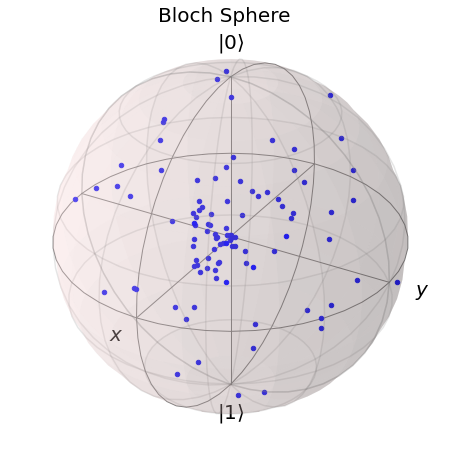

In [35]:
#VISUALIZE DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_noise_free)

In [67]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [68]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

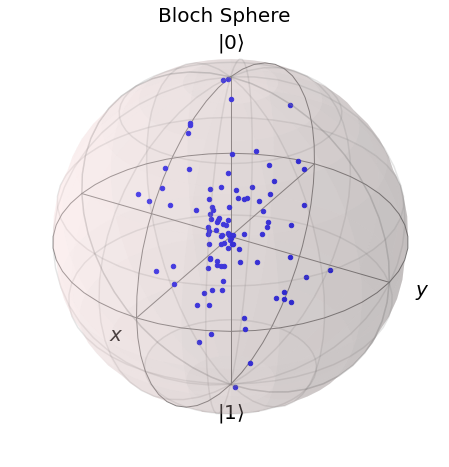

In [38]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_with_noise)

In [69]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:640], bloch_vectors_with_noise[640:720], bloch_vectors_with_noise[720:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:640], bloch_vectors_noise_free[640:720], bloch_vectors_noise_free[720:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [70]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [86]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a*b
  return output

In [91]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(64, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x)
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 dense_46 (Dense)               (None, 64)           256         ['input_38[0][0]']               
                                                                                                  
 dense_47 (Dense)               (None, 64)           4160        ['dense_46[0][0]']               
                                                                                                  
 dense_48 (Dense)               (None, 64)           4160        ['dense_47[0][0]']               
                                                                                           

In [92]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.0001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=64, epochs=500)

Epoch 1/500
10/10 [==============================] - 3s 62ms/step - loss: 0.2118 - val_loss: 0.2106
Epoch 2/500
10/10 [==============================] - 0s 24ms/step - loss: 0.1933 - val_loss: 0.1953
Epoch 3/500
10/10 [==============================] - 0s 19ms/step - loss: 0.1789 - val_loss: 0.1805
Epoch 4/500
10/10 [==============================] - 0s 13ms/step - loss: 0.1650 - val_loss: 0.1644
Epoch 5/500
10/10 [==============================] - 0s 12ms/step - loss: 0.1489 - val_loss: 0.1444
Epoch 6/500
10/10 [==============================] - 0s 12ms/step - loss: 0.1276 - val_loss: 0.1205
Epoch 7/500
10/10 [==============================] - 0s 14ms/step - loss: 0.1039 - val_loss: 0.0964
Epoch 8/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0883 - val_loss: 0.0774
Epoch 9/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0754 - val_loss: 0.0632
Epoch 10/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0617 - val_loss: 0.0507

10/10 [==============================] - 0s 11ms/step - loss: 0.0269 - val_loss: 0.0281
Epoch 83/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0267 - val_loss: 0.0279
Epoch 84/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0269 - val_loss: 0.0282
Epoch 85/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0271 - val_loss: 0.0284
Epoch 86/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0272 - val_loss: 0.0284
Epoch 87/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0274 - val_loss: 0.0288
Epoch 88/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0277 - val_loss: 0.0287
Epoch 89/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0278 - val_loss: 0.0290
Epoch 90/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0279 - val_loss: 0.0293
Epoch 91/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0280 - val_loss: 0.0291
Epo

10/10 [==============================] - 0s 15ms/step - loss: 0.0356 - val_loss: 0.0357
Epoch 163/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0357 - val_loss: 0.0355
Epoch 164/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0353 - val_loss: 0.0360
Epoch 165/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0368 - val_loss: 0.0367
Epoch 166/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0352 - val_loss: 0.0360
Epoch 167/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0369 - val_loss: 0.0370
Epoch 168/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0357 - val_loss: 0.0357
Epoch 169/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0353 - val_loss: 0.0361
Epoch 170/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0360 - val_loss: 0.0360
Epoch 171/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0366 - val_loss: 0

10/10 [==============================] - 0s 13ms/step - loss: 0.0412 - val_loss: 0.0382
Epoch 243/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0396 - val_loss: 0.0384
Epoch 244/500
10/10 [==============================] - 0s 22ms/step - loss: 0.0403 - val_loss: 0.0390
Epoch 245/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0400 - val_loss: 0.0382
Epoch 246/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0395 - val_loss: 0.0388
Epoch 247/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0406 - val_loss: 0.0402
Epoch 248/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0396 - val_loss: 0.0381
Epoch 249/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0394 - val_loss: 0.0378
Epoch 250/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0398 - val_loss: 0.0383
Epoch 251/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0398 - val_loss: 0

10/10 [==============================] - 0s 11ms/step - loss: 0.0401 - val_loss: 0.0385
Epoch 323/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0418 - val_loss: 0.0375
Epoch 324/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0413 - val_loss: 0.0389
Epoch 325/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0415 - val_loss: 0.0384
Epoch 326/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0410 - val_loss: 0.0379
Epoch 327/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0411 - val_loss: 0.0389
Epoch 328/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0418 - val_loss: 0.0385
Epoch 329/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0415 - val_loss: 0.0388
Epoch 330/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0415 - val_loss: 0.0377
Epoch 331/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0415 - val_loss: 0

10/10 [==============================] - 0s 13ms/step - loss: 0.0415 - val_loss: 0.0370
Epoch 403/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0416 - val_loss: 0.0390
Epoch 404/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0409 - val_loss: 0.0376
Epoch 405/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0420 - val_loss: 0.0371
Epoch 406/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0418 - val_loss: 0.0384
Epoch 407/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0397 - val_loss: 0.0381
Epoch 408/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0367
Epoch 409/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0416 - val_loss: 0.0381
Epoch 410/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0412 - val_loss: 0.0384
Epoch 411/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0417 - val_loss: 0

10/10 [==============================] - 0s 12ms/step - loss: 0.0417 - val_loss: 0.0382
Epoch 483/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0418 - val_loss: 0.0365
Epoch 484/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0423 - val_loss: 0.0381
Epoch 485/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0414 - val_loss: 0.0385
Epoch 486/500
10/10 [==============================] - 0s 14ms/step - loss: 0.0418 - val_loss: 0.0371
Epoch 487/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0420 - val_loss: 0.0379
Epoch 488/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0417 - val_loss: 0.0379
Epoch 489/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0426 - val_loss: 0.0368
Epoch 490/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0417 - val_loss: 0.0384
Epoch 491/500
10/10 [==============================] - 0s 15ms/step - loss: 0.0421 - val_loss: 0

In [93]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

3/3 - 0s - loss: 0.0389 - 74ms/epoch - 25ms/step


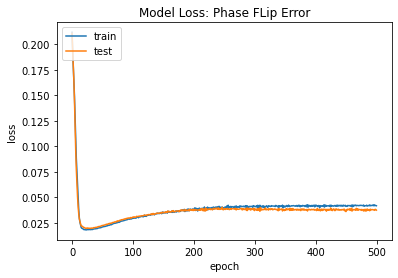

In [94]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()